In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import pandas as pd
import pickle
import random
import tensorflow as tf
import os
import sys
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import gaussian_kde, norm
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

from vae.vae import SVAE
from vae.train import train,train_new
from utils.data_processing import prep_data, make_tf_batches, seq_to_onehot
from vae.predict import predict
from utils.utils_f4f import heatmap, si_format
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'


#### Data_preparetion


In [6]:
# Import data 
assay = 'nor_package'  # nor_package
array = 'seq'    #  RNA


df_all = pd.read_csv('../data/1st_780w_packseq_aa.tsv',delimiter='\t')
df_all = df_all.rename(columns={'aa':'AA_sequence'})
df = df_all[['seq', 'nor_package']]
df= df.sort_values(by='nor_package')

#Fill in the nan data and replace the inf value
df['nor_package'] = df['nor_package'].fillna(0)  
df['nor_package'] = df['nor_package'].replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['nor_package','seq'])
df = df.iloc[::50000]
df

,seq,nor_package
1467121,AGTAGGTATAGTAGTAAGCAT,-8.48312
2887380,CATGCTTTGTTTTTGATGCTT,-6.01783
3488076,CGTGGGATTCCTTGGAAGAAG,-5.75909
4806575,GCTACGCGGGCGTCGAAGGGT,-5.59559
4638593,GCGAATTGGGGGAAGAGGCGT,-5.45424
...,...,...
5910152,GTGGTGGAGTTTGGTTTGGGT,2.76708
2740617,CAGTTGATTGATAGGAAGGCG,2.96337
4994293,GGGAAGATTGCTCCGGTTGAG,3.22364
8350312,TTGGGGGATTCTAGTTTTTTT,3.64682


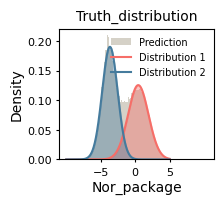

In [7]:
nor_package = df_all[np.isfinite(df_all[assay])][assay]
data = np.array(nor_package) 
data = data.reshape(-1, 1)  # Convert the data into a column vector

# Fit the data using GaussianMixture
n_components = 2 # Set the number of components for the hybrid model
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Get the mean and covariance matrix for each component
means = gmm.means_
covariances = gmm.covariances_

# Generate the fitted distribution
x = np.linspace(-10, 5, 10000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# Plot the raw data and the distribution after fitting
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')

# 绘制每个分量的正态分布
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)


plt.title('Truth_distribution',fontsize=10)
ax.tick_params(axis='both', which='both', length=2,labelsize=8)
ax.set_xticks([-5, 0, 5]); 
# ax.set_yticks([])
plt.ylabel('Density',labelpad=2,fontsize=10)
plt.xlabel('Nor_package',labelpad=2,fontsize=10)
plt.legend(fontsize=7,frameon=False,loc='best')
plt.show()

### Prep data and make Tensorflow-compatible data batches

`prep_data()` will one-hot encode the `AA_sequence` column and split the data into
training and test sets. The training split will be split
futher into training and validation batches with `make_tf_batches()`.


In [8]:
(data_list, train_df, test_df, prepped_df) = prep_data(df, AA_colname=array,target_assay_col=assay)
train_df['Y--nor_package'] = train_df['seq'].map(df.drop_duplicates('seq').set_index('seq')['nor_package'])
test_df['Y--nor_package'] = test_df['seq'].map(df.drop_duplicates('seq').set_index('seq')['nor_package'])
prepped_df['Y--nor_package'] = test_df['seq'].map(df.drop_duplicates('seq').set_index('seq')['nor_package'])

Now we split `train_df` into TensorFlow-compatible training and validation batches using
`make_tf_batches()`. `unbatched_data` is a tuple of Numpy arrays corresponding to the X, Y
and CV (if using) values across both the training and validation batches.


In [9]:
X, Y = data_list
train_batches, val_batches, unbatched_data = make_tf_batches(X, Y)

## SVAE training

Default parameterization (used in paper):

- `input_dim = 140`
- `latent_dim = 2`
- `enc_hidden_dims = [100,40]`
- `dec_hidden_dims = [40,100]`
- `reg_hidden_dims = [100,10]`


In [10]:
# SVAE parameters (same as default)
input_dim = 420
latent_dim = 2
enc_hidden_dims = [300,120]
dec_hidden_dims = [120,300]
reg_hidden_dims = [300,30]

# training parameters 
loss_weights = [1.0,0.8,1.5] # [reconstruction, KL, regression]

initial_learning_rate = 5e-3
optimizer = tf.keras.optimizers.Adam(initial_learning_rate)

outpath = 'pretrain/vae/1st_seq_nor_package'

initial_learning_rate = 5e-3
optimizer = tf.keras.optimizers.Adam(initial_learning_rate)

# Initialize SVAE model (with default parameterizations)
model = SVAE(input_dim=420, latent_dim=6, enc_hidden_dims=[300,120], dec_hidden_dims=[120,300], reg_hidden_dims=[300,30], name='svae')
model.summary()

Model: "svae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 420)]                0         []                            
                                                                                                  
 encoder (Functional)        [(None, 6),                  163872    ['encoder_input[0][0]',       
                              (None, 6),                             'encoder_input[0][0]']       
                              (None, 6)]                                                          
                                                                                                  
 tf.concat_1 (TFOpLambda)    (None, 426)                  0         ['encoder[1][0]',             
                                                                     'encoder_input[0][0]']    

The `train()` function returns the trained `model` and `preds_df`, a DataFrame of
regressor predictions on the X values in `unbatched_data`, along with their latent space
projections and their true Y values.

`train()` saves the trained model, as well as a log of the training and validation loss
values per epoch and `preds_df`, to disk. These saves will be made to an optional
parameter `model_outdir` - if not specified, `train()` will make a new,
informatively-named directory to write to (path is returned).

In [11]:
# Train model
model, preds_df, model_outdir = train_new(model, train_batches, val_batches, array,outpath,train_df, 
                        optimizer=optimizer,
                        loss_weights=loss_weights           
                        )


Logging following metrics: ['train_model_loss', 'train_reconstruction_loss', 'train_kl_loss', 'train_regression_loss', 'val_model_loss', 'val_reconstruction_loss', 'val_kl_loss', 'val_regression_loss']


----- Beginning training. -----

epoch 1
77/77 [==============================] - 1s 19ms/step - train_model_loss: 63.9468 - train_reconstruction_loss: 52.5224 - train_kl_loss: 0.9191 - train_regression_loss: 7.1183 - val_model_loss: 36.9962 - val_reconstruction_loss: 27.5871 - val_kl_loss: 1.7217 - val_regression_loss: 5.3545
INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 2
77/77 [==============================] - 1s 15ms/step - train_model_loss: 37.6582 - train_reconstruction_loss: 28.2787 - train_kl_loss: 0.9101 - train_regression_loss: 5.7931 - val_model_loss: 32.6032 - val_reconstruction_loss: 26.2976 - val_kl_loss: 0.6974 - val_regression_loss: 3.8318


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 3
77/77 [==============================] - 1s 18ms/step - train_model_loss: 32.6267 - train_reconstruction_loss: 25.4243 - train_kl_loss: 0.6412 - train_regression_loss: 4.4423 - val_model_loss: 31.7968 - val_reconstruction_loss: 25.4320 - val_kl_loss: 0.8786 - val_regression_loss: 3.7746


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 4
77/77 [==============================] - 1s 17ms/step - train_model_loss: 32.2428 - train_reconstruction_loss: 25.1157 - train_kl_loss: 0.8599 - train_regression_loss: 4.3142 - val_model_loss: 38.7406 - val_reconstruction_loss: 34.1150 - val_kl_loss: 0.5703 - val_regression_loss: 2.7796


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 5
77/77 [==============================] - 2s 20ms/step - train_model_loss: 35.8219 - train_reconstruction_loss: 28.4269 - train_kl_loss: 0.7088 - train_regression_loss: 4.5271 - val_model_loss: 28.3489 - val_reconstruction_loss: 23.7396 - val_kl_loss: 0.7835 - val_regression_loss: 2.6550


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 6
77/77 [==============================] - 1s 17ms/step - train_model_loss: 30.7144 - train_reconstruction_loss: 24.6128 - train_kl_loss: 0.6629 - train_regression_loss: 3.7133 - val_model_loss: 34.5142 - val_reconstruction_loss: 29.3941 - val_kl_loss: 0.5091 - val_regression_loss: 3.1419


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 7
77/77 [==============================] - 1s 15ms/step - train_model_loss: 32.5845 - train_reconstruction_loss: 24.9354 - train_kl_loss: 0.5854 - train_regression_loss: 4.7982 - val_model_loss: 27.1607 - val_reconstruction_loss: 23.6145 - val_kl_loss: 0.5802 - val_regression_loss: 2.0546


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 8
77/77 [==============================] - 1s 17ms/step - train_model_loss: 31.7266 - train_reconstruction_loss: 24.7672 - train_kl_loss: 0.6259 - train_regression_loss: 4.3376 - val_model_loss: 29.6213 - val_reconstruction_loss: 22.3351 - val_kl_loss: 0.7072 - val_regression_loss: 4.4803


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 9
77/77 [==============================] - 2s 20ms/step - train_model_loss: 28.9746 - train_reconstruction_loss: 22.6623 - train_kl_loss: 0.6631 - train_regression_loss: 3.8348 - val_model_loss: 29.4107 - val_reconstruction_loss: 22.8018 - val_kl_loss: 0.5890 - val_regression_loss: 4.0918


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 10
77/77 [==============================] - 1s 16ms/step - train_model_loss: 28.6887 - train_reconstruction_loss: 22.6479 - train_kl_loss: 0.5554 - train_regression_loss: 3.6896 - val_model_loss: 29.1369 - val_reconstruction_loss: 21.6990 - val_kl_loss: 0.5204 - val_regression_loss: 4.6810


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 11
77/77 [==============================] - 1s 16ms/step - train_model_loss: 28.1219 - train_reconstruction_loss: 22.1897 - train_kl_loss: 0.5420 - train_regression_loss: 3.6687 - val_model_loss: 26.4194 - val_reconstruction_loss: 21.4847 - val_kl_loss: 0.5548 - val_regression_loss: 2.9939


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 12
77/77 [==============================] - 1s 19ms/step - train_model_loss: 27.6597 - train_reconstruction_loss: 22.1389 - train_kl_loss: 0.5311 - train_regression_loss: 3.3915 - val_model_loss: 27.6283 - val_reconstruction_loss: 22.4685 - val_kl_loss: 0.4660 - val_regression_loss: 3.1913


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 13
77/77 [==============================] - 1s 15ms/step - train_model_loss: 27.1679 - train_reconstruction_loss: 21.9340 - train_kl_loss: 0.4595 - train_regression_loss: 3.2558 - val_model_loss: 27.1187 - val_reconstruction_loss: 22.1053 - val_kl_loss: 0.4312 - val_regression_loss: 3.1123


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 14
77/77 [==============================] - 1s 13ms/step - train_model_loss: 27.4508 - train_reconstruction_loss: 22.0564 - train_kl_loss: 0.4286 - train_regression_loss: 3.3491 - val_model_loss: 26.2379 - val_reconstruction_loss: 20.9848 - val_kl_loss: 0.4517 - val_regression_loss: 3.2612


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 15
77/77 [==============================] - 1s 19ms/step - train_model_loss: 26.2909 - train_reconstruction_loss: 21.5628 - train_kl_loss: 0.4321 - train_regression_loss: 2.9230 - val_model_loss: 26.2856 - val_reconstruction_loss: 21.0265 - val_kl_loss: 0.4408 - val_regression_loss: 3.2709


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 16
77/77 [==============================] - 1s 18ms/step - train_model_loss: 26.6237 - train_reconstruction_loss: 21.7013 - train_kl_loss: 0.4168 - train_regression_loss: 3.0550 - val_model_loss: 26.6191 - val_reconstruction_loss: 20.8667 - val_kl_loss: 0.4434 - val_regression_loss: 3.5984


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 17
77/77 [==============================] - 1s 16ms/step - train_model_loss: 26.1068 - train_reconstruction_loss: 21.6079 - train_kl_loss: 0.4059 - train_regression_loss: 2.7886 - val_model_loss: 26.7128 - val_reconstruction_loss: 22.3960 - val_kl_loss: 0.3687 - val_regression_loss: 2.6812


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 18
77/77 [==============================] - 1s 15ms/step - train_model_loss: 26.0947 - train_reconstruction_loss: 21.8252 - train_kl_loss: 0.3785 - train_regression_loss: 2.6464 - val_model_loss: 24.9778 - val_reconstruction_loss: 21.2021 - val_kl_loss: 0.3774 - val_regression_loss: 2.3159


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 19
77/77 [==============================] - 1s 13ms/step - train_model_loss: 25.4012 - train_reconstruction_loss: 21.6780 - train_kl_loss: 0.3705 - train_regression_loss: 2.2710 - val_model_loss: 26.5229 - val_reconstruction_loss: 22.0169 - val_kl_loss: 0.3659 - val_regression_loss: 2.8089


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 20
77/77 [==============================] - 1s 15ms/step - train_model_loss: 25.5394 - train_reconstruction_loss: 21.6850 - train_kl_loss: 0.3706 - train_regression_loss: 2.3909 - val_model_loss: 24.8050 - val_reconstruction_loss: 21.2090 - val_kl_loss: 0.3567 - val_regression_loss: 2.2072


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 21
77/77 [==============================] - 1s 15ms/step - train_model_loss: 24.9872 - train_reconstruction_loss: 21.6124 - train_kl_loss: 0.3489 - train_regression_loss: 2.0742 - val_model_loss: 24.5692 - val_reconstruction_loss: 21.6717 - val_kl_loss: 0.3773 - val_regression_loss: 1.7304


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 22
77/77 [==============================] - 1s 16ms/step - train_model_loss: 24.8960 - train_reconstruction_loss: 21.6455 - train_kl_loss: 0.3367 - train_regression_loss: 1.9980 - val_model_loss: 24.1467 - val_reconstruction_loss: 21.0421 - val_kl_loss: 0.3466 - val_regression_loss: 1.8849


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 23
77/77 [==============================] - 1s 15ms/step - train_model_loss: 24.1515 - train_reconstruction_loss: 21.4627 - train_kl_loss: 0.3696 - train_regression_loss: 1.5893 - val_model_loss: 23.1321 - val_reconstruction_loss: 20.8380 - val_kl_loss: 0.3431 - val_regression_loss: 1.3464


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 24
77/77 [==============================] - 1s 14ms/step - train_model_loss: 24.3731 - train_reconstruction_loss: 21.4837 - train_kl_loss: 0.3654 - train_regression_loss: 1.7220 - val_model_loss: 23.7636 - val_reconstruction_loss: 20.8177 - val_kl_loss: 0.3375 - val_regression_loss: 1.7839


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 25
77/77 [==============================] - 1s 15ms/step - train_model_loss: 23.9202 - train_reconstruction_loss: 21.4147 - train_kl_loss: 0.3471 - train_regression_loss: 1.4901 - val_model_loss: 23.1787 - val_reconstruction_loss: 21.1970 - val_kl_loss: 0.3643 - val_regression_loss: 1.1268


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 26
77/77 [==============================] - 1s 15ms/step - train_model_loss: 23.5065 - train_reconstruction_loss: 21.2219 - train_kl_loss: 0.3524 - train_regression_loss: 1.3305 - val_model_loss: 23.2896 - val_reconstruction_loss: 21.3323 - val_kl_loss: 0.3494 - val_regression_loss: 1.1186


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 27
77/77 [==============================] - 1s 16ms/step - train_model_loss: 23.5564 - train_reconstruction_loss: 21.4280 - train_kl_loss: 0.3955 - train_regression_loss: 1.2047 - val_model_loss: 22.3681 - val_reconstruction_loss: 20.5797 - val_kl_loss: 0.4169 - val_regression_loss: 0.9699


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 28
77/77 [==============================] - 1s 15ms/step - train_model_loss: 23.1104 - train_reconstruction_loss: 21.3356 - train_kl_loss: 0.4100 - train_regression_loss: 0.9700 - val_model_loss: 23.5778 - val_reconstruction_loss: 21.7025 - val_kl_loss: 0.4136 - val_regression_loss: 1.0296


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 29
77/77 [==============================] - 1s 17ms/step - train_model_loss: 22.8029 - train_reconstruction_loss: 21.0915 - train_kl_loss: 0.4026 - train_regression_loss: 0.9336 - val_model_loss: 21.8701 - val_reconstruction_loss: 20.1785 - val_kl_loss: 0.4481 - val_regression_loss: 0.8887


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.

epoch 30
77/77 [==============================] - 1s 18ms/step - train_model_loss: 22.6358 - train_reconstruction_loss: 21.1418 - train_kl_loss: 0.4068 - train_regression_loss: 0.7830 - val_model_loss: 22.5216 - val_reconstruction_loss: 20.9610 - val_kl_loss: 0.4248 - val_regression_loss: 0.8138


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.
Convergence history: [0]

epoch 31
77/77 [==============================] - 1s 13ms/step - train_model_loss: 22.2365 - train_reconstruction_loss: 20.7870 - train_kl_loss: 0.4447 - train_regression_loss: 0.7412 - val_model_loss: 21.8939 - val_reconstruction_loss: 20.0734 - val_kl_loss: 0.4621 - val_regression_loss: 0.9672


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.
Convergence history: [0, 0]

epoch 32
77/77 [==============================] - 1s 16ms/step - train_model_loss: 22.3702 - train_reconstruction_loss: 20.8557 - train_kl_loss: 0.4433 - train_regression_loss: 0.7703 - val_model_loss: 21.9458 - val_reconstruction_loss: 20.1835 - val_kl_loss: 0.4279 - val_regression_loss: 0.9466


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.
Convergence history: [0, 0, 0]

epoch 33
77/77 [==============================] - 1s 17ms/step - train_model_loss: 22.0749 - train_reconstruction_loss: 20.7337 - train_kl_loss: 0.4260 - train_regression_loss: 0.6705 - val_model_loss: 21.5291 - val_reconstruction_loss: 20.4776 - val_kl_loss: 0.4636 - val_regression_loss: 0.4537


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.
Convergence history: [0, 0, 0, 1]

epoch 34
77/77 [==============================] - 1s 13ms/step - train_model_loss: 21.5960 - train_reconstruction_loss: 20.3725 - train_kl_loss: 0.4569 - train_regression_loss: 0.5765 - val_model_loss: 21.4250 - val_reconstruction_loss: 20.1325 - val_kl_loss: 0.4683 - val_regression_loss: 0.6119


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.
Convergence history: [0, 0, 0, 1, 0]

epoch 35
77/77 [==============================] - 1s 16ms/step - train_model_loss: 21.9361 - train_reconstruction_loss: 20.7797 - train_kl_loss: 0.4742 - train_regression_loss: 0.5234 - val_model_loss: 21.0561 - val_reconstruction_loss: 20.1843 - val_kl_loss: 0.4795 - val_regression_loss: 0.3254


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.
Convergence history: [0, 0, 0, 1, 0, 0]

epoch 36
77/77 [==============================] - 1s 14ms/step - train_model_loss: 21.7096 - train_reconstruction_loss: 20.5564 - train_kl_loss: 0.4811 - train_regression_loss: 0.5121 - val_model_loss: 21.3199 - val_reconstruction_loss: 20.5296 - val_kl_loss: 0.4606 - val_regression_loss: 0.2813


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.
Convergence history: [0, 0, 0, 1, 0, 0, 0]

epoch 37
77/77 [==============================] - 1s 15ms/step - train_model_loss: 20.8452 - train_reconstruction_loss: 19.7870 - train_kl_loss: 0.5125 - train_regression_loss: 0.4349 - val_model_loss: 21.1720 - val_reconstruction_loss: 20.0903 - val_kl_loss: 0.4989 - val_regression_loss: 0.4551


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.
Convergence history: [0, 0, 0, 1, 0, 0, 0, 0]

epoch 38
77/77 [==============================] - 1s 16ms/step - train_model_loss: 21.3546 - train_reconstruction_loss: 20.3845 - train_kl_loss: 0.5223 - train_regression_loss: 0.3720 - val_model_loss: 20.6829 - val_reconstruction_loss: 19.8492 - val_kl_loss: 0.5686 - val_regression_loss: 0.2526


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.
Convergence history: [0, 0, 0, 1, 0, 0, 0, 0, 0]

epoch 39
77/77 [==============================] - 1s 17ms/step - train_model_loss: 20.8994 - train_reconstruction_loss: 19.9714 - train_kl_loss: 0.5375 - train_regression_loss: 0.3332 - val_model_loss: 21.0368 - val_reconstruction_loss: 19.9351 - val_kl_loss: 0.5230 - val_regression_loss: 0.4556


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.
Convergence history: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

epoch 40
77/77 [==============================] - 1s 18ms/step - train_model_loss: 21.1329 - train_reconstruction_loss: 20.1322 - train_kl_loss: 0.5117 - train_regression_loss: 0.3877 - val_model_loss: 20.1661 - val_reconstruction_loss: 19.5398 - val_kl_loss: 0.5291 - val_regression_loss: 0.1354


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_package\assets


Model saved to pretrain/vae/1st_aa_nor_package.
Hit maximum epochs.
Finished training model. Final overall losses:
train: 21.133    val:20.166
5/5 [==============================] - 0s 2ms/step

MSE of predictions vs true labels: 0.20209750533103943


INFO:tensorflow:Assets written to: e:\Elite\Now_repority\20240220\trained_models\2024419_nor_package_6D_40epochs_21.13T_20.17V\model\assets


INFO:tensorflow:Assets written to: e:\Elite\Now_repority\20240220\trained_models\2024419_nor_package_6D_40epochs_21.13T_20.17V\model\assets


Model saved to e:\Elite\Now_repority\20240220\trained_models\2024419_nor_package_6D_40epochs_21.13T_20.17V\model.
Losses saved to e:\Elite\Now_repority\20240220\trained_models\2024419_nor_package_6D_40epochs_21.13T_20.17V\loss_log.csv.
Train predictions saved to e:\Elite\Now_repority\20240220\trained_models\2024419_nor_package_6D_40epochs_21.13T_20.17V\preds.csv.


####  Correlation between result and prediction 

d:\ProgramData\anaconda3\envs\tf\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


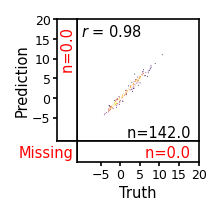

In [12]:


x = preds_df['y_pred']
y = preds_df['y_true']

remove = np.isinf(x) & np.isinf(y)
x = x[~remove]
y = y[~remove]

keep = (~np.isinf(x)) & (~np.isinf(y))
x_both = x[keep]
y_both = y[keep]

y_missing = y[np.isinf(x)]
x_missing = x[np.isinf(y)]


kernel = gaussian_kde(np.vstack([
    x_both.sample(n=100, random_state=1), 
    y_both.sample(n=100, random_state=1)
]))
c_both = kernel(np.vstack([x_both.values, y_both.values]))


fig = plt.figure(figsize=(1.4,1.3), dpi=150)

gs = fig.add_gridspec(2, 2, left=0.275, right=0.95, bottom=0.22, top=0.95, 
                      width_ratios=[1, 6], height_ratios=[6, 1], hspace=0., wspace=0)
ax = fig.add_subplot(gs[0, 1])
ax.scatter(x_both, y_both, c=c_both, cmap=mpl.cm.inferno, s=0.2, edgecolor='none', rasterized=True)
ax.set_xticks([]); ax.set_yticks([])
xlim = [-11, 12]
bins = np.linspace(*xlim, 25)
ax.set_xlim(xlim); ax.set_ylim(xlim)
ax.text(0.03, 0.97, r'$r$ = {:.2f}'.format(np.corrcoef(x_both, y_both)[0, 1]),
       transform=ax.transAxes, ha='left', va='top', fontsize=7)

ax.text(0.97, 0.01, 'n={}'.format(si_format(len(x_both)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='bottom', fontsize=7)

# Left Marginal
ax = fig.add_subplot(gs[0, 0])
ax.hist(y_missing, bins=bins, edgecolor='none', orientation='horizontal', density=True, color='r')
ax.set_ylim(xlim)
ax.set_xticks([]); ax.set_yticks([-5, 0, 5, 10, 15,20])
ax.text(0.97, 0.97, 'n={}'.format(si_format(len(y_missing)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, rotation=90, color='r')
ax.set_ylabel('Prediction', labelpad=1,fontsize=7)
ax.tick_params(axis='both', labelsize=6, length=2, pad=1)

# Bottom Marginal
ax = fig.add_subplot(gs[1, 1])
ax.hist(x_missing, bins=bins, edgecolor='none', density=True, color='r')
ax.set_xlim(xlim)
ax.set_xticks([-5, 0, 5, 10, 15,20]); ax.set_yticks([])
ax.text(0.97, 0.8, 'n={}'.format(si_format(len(x_missing)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, color='r')
ax.set_xlabel('Truth', labelpad=2,fontsize=7)
ax.tick_params(axis='both', labelsize=6, length=2, pad=1)


# Missing label (not detected in either)
ax = fig.add_subplot(gs[1, 0])
for spine in ['bottom', 'left']:
    ax.spines[spine].set_visible(False)
ax.set_xticks([]); ax.set_yticks([])

ax.text(0.8, 0.8, 'Missing', transform=ax.transAxes, color='r', ha='right', va='top', fontsize=7, clip_on=False)
fig.savefig('../results/vae/1st_results/nor_package/1st_vae_rna_nor_package_correlation_train.pdf',dpi=300,bbox_inches='tight')

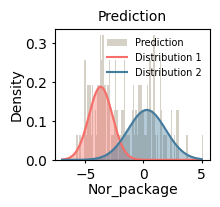

In [13]:

data = np.array(preds_df['y_pred']) 
data = data.reshape(-1, 1)  # Convert the data into a column vector

# Fit the data using GaussianMixture
n_components = 2 # Set the number of components for the hybrid model
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Get the mean and covariance matrix for each component
means = gmm.means_
covariances = gmm.covariances_

# Generate the fitted distribution
x = np.linspace(-7, 5, 100000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# Plot the raw data and the distribution after fitting
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')

# 绘制每个分量的正态分布
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)


plt.title('Prediction',fontsize=10)
ax.tick_params(axis='both', which='both', length=2,labelsize=10)
ax.set_xticks([-5, 0, 5]); 
# ax.set_yticks([])
plt.ylabel('Density',labelpad=1,fontsize=10)
plt.xlabel('Nor_package',labelpad=1,fontsize=10)
plt.legend(fontsize=7,frameon=False)
plt.show()
fig.savefig('../results/vae/1st_results/nor_package/1st_vae_seq_nor_package_distribution_train.pdf',dpi=300,bbox_inches='tight')

In [14]:
AA = test_df[array].values
X = test_df.drop(columns=[array,'Y--nor_package'])
Y = test_df['Y--nor_package'].values
preds_df = predict(model, X, array,Y=Y, AA=AA)
preds_df['y_pred'].corr(preds_df['y_true'])

1/1 [==============================] - 0s 23ms/step

MSE of predictions vs true labels: 0.20373272895812988


0.9853515937555002

In [ ]:


x = preds_df['y_pred']
y = preds_df['y_true']

remove = np.isinf(x) & np.isinf(y)
x = x[~remove]
y = y[~remove]

keep = (~np.isinf(x)) & (~np.isinf(y))
x_both = x[keep]
y_both = y[keep]

y_missing = y[np.isinf(x)]
x_missing = x[np.isinf(y)]


kernel = gaussian_kde(np.vstack([
    x_both.sample(n=100, random_state=1), 
    y_both.sample(n=100, random_state=1)
]))
c_both = kernel(np.vstack([x_both.values, y_both.values]))


fig = plt.figure(figsize=(1.4,1.3), dpi=150)

gs = fig.add_gridspec(2, 2, left=0.275, right=0.95, bottom=0.22, top=0.95, 
                      width_ratios=[1, 6], height_ratios=[6, 1], hspace=0., wspace=0)
ax = fig.add_subplot(gs[0, 1])
ax.scatter(x_both, y_both, c=c_both, cmap=mpl.cm.inferno, s=0.2, edgecolor='none', rasterized=True)
ax.set_xticks([]); ax.set_yticks([])
xlim = [-11, 12]
bins = np.linspace(*xlim, 25)
ax.set_xlim(xlim); ax.set_ylim(xlim)
ax.text(0.03, 0.97, r'$r$ = {:.2f}'.format(np.corrcoef(x_both, y_both)[0, 1]),
       transform=ax.transAxes, ha='left', va='top', fontsize=7)

ax.text(0.97, 0.01, 'n={}'.format(si_format(len(x_both)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='bottom', fontsize=7)

# Left Marginal
ax = fig.add_subplot(gs[0, 0])
ax.hist(y_missing, bins=bins, edgecolor='none', orientation='horizontal', density=True, color='r')
ax.set_ylim(xlim)
ax.set_xticks([]); ax.set_yticks([-5, 0, 5, 10, 15,20])
ax.text(0.97, 0.97, 'n={}'.format(si_format(len(y_missing)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, rotation=90, color='r')
ax.set_ylabel('Prediction', labelpad=1,fontsize=7)
ax.tick_params(axis='both', labelsize=6, length=2, pad=1)

# Bottom Marginal
ax = fig.add_subplot(gs[1, 1])
ax.hist(x_missing, bins=bins, edgecolor='none', density=True, color='r')
ax.set_xlim(xlim)
ax.set_xticks([-5, 0, 5, 10, 15,20]); ax.set_yticks([])
ax.text(0.97, 0.8, 'n={}'.format(si_format(len(x_missing)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, color='r')
ax.set_xlabel('Truth', labelpad=2,fontsize=7)
ax.tick_params(axis='both', labelsize=6, length=2, pad=1)


# Missing label (not detected in either)
ax = fig.add_subplot(gs[1, 0])
for spine in ['bottom', 'left']:
    ax.spines[spine].set_visible(False)
ax.set_xticks([]); ax.set_yticks([])

ax.text(0.8, 0.8, 'Missing', transform=ax.transAxes, color='r', ha='right', va='top', fontsize=7, clip_on=False)
fig.savefig('../results/vae/1st_results/nor_package/1st_vae_rna_nor_package_correlation_test.pdf',dpi=300,bbox_inches='tight')

In [ ]:

data = np.array(preds_df['y_pred']) 
data = data.reshape(-1, 1)  # Convert the data into a column vector

# Fit the data using GaussianMixture
n_components = 2 # Set the number of components for the hybrid model
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Get the mean and covariance matrix for each component
means = gmm.means_
covariances = gmm.covariances_

# Generate the fitted distribution
x = np.linspace(-7, 5, 100000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# Plot the raw data and the distribution after fitting
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')

# 绘制每个分量的正态分布
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)


plt.title('Prediction',fontsize=10)
ax.tick_params(axis='both', which='both', length=2,labelsize=10)
ax.set_xticks([-5, 0, 5]); 
# ax.set_yticks([])
plt.ylabel('Density',labelpad=1,fontsize=10)
plt.xlabel('Nor_package',labelpad=1,fontsize=10)
plt.legend(fontsize=7,frameon=False)
plt.show()
fig.savefig('../results/vae/1st_results/nor_package/1st_vae_seq_nor_package_distribution_test.pdf',dpi=300,bbox_inches='tight')